In [0]:
# Import libs

import pandas as pd
import re
import numpy as np

In [0]:
# Load Training, Dev and Test Data

def loadData(filepath):
  data = pd.read_csv(filepath)
  # Currently working on region level predictor
  data.drop(['lat','long','state'],axis=1,inplace=True)
  # Filter and remove anomaly data
  data = data[data.region != 'MX']  # Remove 'Mexico' records - Due to Reverse geocoding
  data = data[data.region != 'CA']  # Remove 'Canada' records - Due to Reverse geocoding
  data.dropna(inplace=True)
  data.reset_index(drop=True,inplace=True)
  return data

# train file and dev file has columns tweet, lat, long, state, region
# test file has columns uid (userid), tweet, lat, long, state, region
train = loadData("Path to train .csv file")
dev = loadData("Path to dev .csv file")
test = loadData("Path to test .csv file")
tweet_test = test.drop('uid', axis=1)  # Tweet level test
user_test = test.drop('tweet', axis=1).drop_duplicates()  # User level test

# print(train.head(5))
# print(train.iloc[0])
# dev.region.unique()
# train.info()
print("Train shape: "+ str(train.shape))
print("Dev shape: "+ str(dev.shape))
print("Test shape: "+ str(test.shape))
print("Tweet Test shape: "+ str(tweet_test.shape))
print("User Test shape: "+ str(user_test.shape))

Train shape: (292226, 2)
Dev shape: (74079, 2)
Test shape: (74382, 3)
Tweet Test shape: (74382, 2)
User Test shape: (1858, 2)


In [0]:
"""
preprocess-twitter.py

Script for preprocessing tweets by Romain Paulus
with small modifications by Jeffrey Pennington
with translation to Python by Motoki Wu

Translation of Ruby script to create features for GloVe vectors for Twitter data.
http://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
"""

import sys
import regex as re

FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = " {} ".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"


def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\S+", hashtag)
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", allcaps)

    return text.lower()

In [0]:
# Data Preparation

# Tweet cleaning
pat1 = r'@[A-Za-z0-9_]+'  # To remove '@' mentions
pat2 = r'https?://[^ ]+'  # To remove web links starting with http
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'  # To remove web links starting without http

def tweet_cleaner(text):
    # stripped = re.sub(combined_pat, '', text)
    # stripped = re.sub(www_pat, '', stripped)
    return tokenize(text)
  
# print(tweet_cleaner(" www.msundarv.com don't First batting also dhik dhik, chasing also dhik dhik! Finger nails, toe nails, no bias! 😷 #Yellove #WhistlePodu #CSKvRR 🦁💛"))

train.tweet = train.tweet.apply(tweet_cleaner)
# print(train.head(5))
# print(train.iloc[0])
dev.tweet = dev.tweet.apply(tweet_cleaner)
tweet_test.tweet = tweet_test.tweet.apply(tweet_cleaner)

print("Train shape: "+ str(train.shape))
print("Dev shape: "+ str(dev.shape))
print("Test shape: "+ str(tweet_test.shape))

Train shape: (292226, 2)
Dev shape: (74079, 2)
Test shape: (74382, 2)


In [0]:
# Create Glove Twitter Word Embedding Matrix

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [0]:
# Vectorization

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tweet_tokenizer = Tokenizer()
tweet_tokenizer.fit_on_texts(train.tweet)
tweet_vocab_size = len(tweet_tokenizer.word_index) + 1
print("Vocab size: "+ str(tweet_vocab_size))

X_train = tweet_tokenizer.texts_to_sequences(train.tweet)
X_dev = tweet_tokenizer.texts_to_sequences(dev.tweet)
X_test = tweet_tokenizer.texts_to_sequences(tweet_test.tweet)

tweet_len = 25
X_train = pad_sequences(X_train, padding='post', maxlen=tweet_len)
X_dev = pad_sequences(X_dev, padding='post', maxlen=tweet_len)
X_test = pad_sequences(X_test, padding='post', maxlen=tweet_len)

print("X_Train shape: "+ str(X_train.shape))
print("X_Dev shape: "+ str(X_dev.shape))
print("X_Test shape: "+ str(X_test.shape))

embedding_dim = 100
embedding_matrix = create_embedding_matrix('Path to glove.twitter.27B.100d.txt', tweet_tokenizer.word_index, embedding_dim)
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print("Vocab covered:  {:.2f}".format((nonzero_elements / tweet_vocab_size)*100))

y_train = to_categorical(train.region.replace({ 'midwest': 0, 'northeast': 1, 'south': 2, 'west' : 3 }), num_classes=None)
y_dev = to_categorical(dev.region.replace({ 'midwest': 0, 'northeast': 1, 'south': 2, 'west' : 3 }), num_classes=None)
y_test = to_categorical(tweet_test.region.replace({ 'midwest': 0, 'northeast': 1, 'south': 2, 'west' : 3 }), num_classes=None)

Using TensorFlow backend.


Vocab size: 101054
X_Train shape: (292226, 25)
X_Dev shape: (74079, 25)
X_Test shape: (74382, 25)
Vocab covered:  60.37


In [0]:
# Define LSTM Model

from keras.models import Sequential
from keras import layers

def create_model(no_of_units, no_of_layers):
  print("[No. of units, No. of layers]: "+ str([no_of_units, no_of_layers]))
  model = Sequential()
  model.add(layers.Embedding(tweet_vocab_size, embedding_dim, 
                             weights=[embedding_matrix],
                             input_length = tweet_len,
                             trainable = True))
  
  for i in range(no_of_layers):
    if i == (no_of_layers - 1):
      model.add(layers.Bidirectional(layers.LSTM(no_of_units, dropout = 0.2)))
    else:
      model.add(layers.Bidirectional(layers.LSTM(no_of_units, dropout = 0.2, return_sequences=True)))
  model.add(layers.Dense(no_of_units, activation='relu'))
  model.add(layers.GaussianNoise(0.2)) 
  model.add(layers.Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [0]:
# Hyperparameters Optimization

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = dict(no_of_units=[10, 15, 20, 25, 30], no_of_layers = [2, 3, 4])

model = KerasClassifier(build_fn=create_model, epochs=3, batch_size=128, verbose=1)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3, verbose=1, n_iter=7)
grid_result = grid.fit(X_train, y_train)

print("Best Grid Score:  {:.2f}".format(grid_result.best_score_*100))
print("Best Grid params: "+ str(grid_result.best_params_))

lstm_grid_accuracy = grid.score(X_test, y_test)
print("LSTM Grid Test Accuracy:  {:.2f}".format(lstm_grid_accuracy*100))

# Best params {'no_of_units': 10, 'no_of_layers': 3}

In [ ]:
# Train and predict using LSTM

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

model = create_model(10,3) 

# Save the checkpoint
ckptfilepath = "Path to .hdf5 checkpopint file"

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(ckptfilepath,
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

early_stopping_monitor = EarlyStopping(patience=10)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_dev, y_dev), batch_size=10000, callbacks=[checkpoint, early_stopping_monitor])
# history = model.fit(X_train, y_train, epochs=3, validation_data=(X_dev, y_dev), batch_size=128, callbacks=[checkpoint])

lstm_loss, lstm_accuracy = model.evaluate(X_test, y_test, verbose=False)
print("LSTM Test Accuracy:  {:.2f}".format(lstm_accuracy*100))

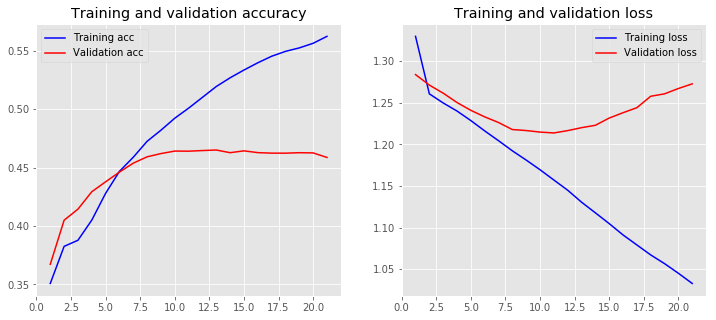

In [0]:
 # Plot training loss values and metrics values 

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [0]:
# Evaluate best fit LSTM

from sklearn.metrics import accuracy_score

bestmodelfilepath = "Path to best model .hdf5 file"

model = create_model(10,3)
model.load_weights(bestmodelfilepath)

lstm_loss, lstm_accuracy = model.evaluate(X_test, y_test, verbose=False)
print("LSTM Best Tweet level Test Accuracy:  {:.2f}".format(lstm_accuracy*100))


# Predict tweet level regions using trained model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
# print(y_pred.shape)

# Predict user level region
test['ypred'] = y_pred
user_pred = test.drop(['tweet','region'],axis=1)
pred = user_pred.groupby(['uid'])['ypred'].agg(lambda x:x.value_counts().index[0])
# print(pred.head(10))

# Compare with true values
true = user_test.sort_values(by=['uid']).replace({ 'midwest': 0, 'northeast': 1, 'south': 2, 'west' : 3 })
# print(true.head(10))

final_acc = accuracy_score(true['region'], pred)
print("LSTM Final Accuracy:  {:.2f}".format(final_acc*100))

[No. of units, No. of layers]: [10, 3]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           10105400  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 20)            8880      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 25, 20)            2480      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20)                2480      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
________________________________________________



---

